# Hospitality Heuristics: Reviewing Revenues

---

- Data: hotel datasets from capstone
- Goal: Design/develop on-demand report generation for common metrics
- Breakdown:
    - Calculate daily revenue(s)
    - Calculate daily occupancy
        - By room type
        - By rate segmentation
        - By rate amount (e.g., quartiles, etc.)

---

In [44]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

import seaborn as sns

import shap

from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import xgboost as xgb

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
data_path_resort = './data/Resort_Data.xlsx'
data_path_city = './data/City_Data.xlsx'

In [3]:
resort_df = pd.read_excel(data_path_resort)
resort_df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [4]:
resort_df['IsCanceled'].value_counts(dropna = False, normalize = True)

IsCanceled
0   0.72
1   0.28
Name: proportion, dtype: float64

In [5]:
resort_df.select_dtypes(include = "number")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,0,342,2015,27,1,0,0,2,0,0,0,0,0,3,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0,0,0,0,0,4,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0,0,0,0,0,0,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,35,31,2,8,2,1,0,0,0,0,1,0,89.75,0,0
40056,0,169,2017,35,30,2,9,2,0,0,0,0,0,0,0,202.27,0,1
40057,0,204,2017,35,29,4,10,2,0,0,0,0,0,0,0,153.57,0,3
40058,0,211,2017,35,31,4,10,2,0,0,0,0,0,0,0,112.80,0,1


In [6]:
features = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
            'ArrivalDateWeekNumber', 'IsRepeatedGuest', 'PreviousCancellations',
            'PreviousBookingsNotCanceled', 'BookingChanges']

In [7]:
# Assuming 'df' is your DataFrame
X = resort_df.loc[:, features] # Features
y = resort_df['IsCanceled']   # Target variable

In [8]:
# X.dtypes

In [9]:
# y

In [10]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss')

# Train the classifier
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [11]:
# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      5798
           1       0.76      0.34      0.47      2214

    accuracy                           0.79      8012
   macro avg       0.77      0.65      0.67      8012
weighted avg       0.78      0.79      0.76      8012



In [13]:
# X.describe().T

## HistGradientBoostingRegressor

In [14]:
# Instantiate the model
regressor = HistGradientBoostingRegressor()

# Train the model
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

In [15]:
# Evaluate the model
mse = round(mean_squared_error(y_test, y_pred), 4)
rmse = round(np.sqrt(mse), 4)

print(f'The MSE is: {mse}. The RMSE is: {rmse}.')

The MSE is: 0.1503. The RMSE is: 0.3877.


In [16]:
# Instantiate the classifier
classifier = HistGradientBoostingClassifier()

# Train the classifier
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 77.73%

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      5798
           1       0.79      0.26      0.40      2214

    accuracy                           0.78      8012
   macro avg       0.78      0.62      0.63      8012
weighted avg       0.78      0.78      0.73      8012



# Imbalanced-Learn

In [17]:
# Create the classifier
brf_classifier = BalancedRandomForestClassifier(random_state=42)

# Train the classifier
brf_classifier.fit(X_train, y_train)

# Predictions
y_pred = brf_classifier.predict(X_test)

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.


In [18]:
# Evaluate the classifier
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      5798
           1       0.52      0.73      0.61      2214

    accuracy                           0.74      8012
   macro avg       0.70      0.74      0.71      8012
weighted avg       0.78      0.74      0.75      8012



In [19]:
# Applying SMOTE to generate synthetic samples for the minority class
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

smote_enn = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)


In [20]:


# Create a classifier
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      5798
           1       0.85      0.92      0.88      2214

    accuracy                           0.93      8012
   macro avg       0.91      0.93      0.92      8012
weighted avg       0.93      0.93      0.93      8012



# City Data

In [21]:
data_path_city = './data/City_Data.xlsx'

In [22]:
features = ['IsCanceled', 'LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
            'ArrivalDateWeekNumber', 'IsRepeatedGuest', 'PreviousCancellations',
            'PreviousBookingsNotCanceled', 'BookingChanges']

In [23]:
city_df = pd.read_excel(data_path_city, usecols= features)
city_df

,IsCanceled,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges
0,0,6,27,0,2,0,0,0,0
1,1,88,27,0,4,0,0,0,0
2,1,65,27,0,4,0,0,0,0
3,1,92,27,2,4,0,0,0,0
4,1,100,27,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...
79325,0,23,35,2,5,0,0,0,0
79326,0,102,35,2,5,0,0,0,0
79327,0,34,35,2,5,0,0,0,0
79328,0,109,35,2,5,0,0,0,0


In [24]:
# Assuming 'df' is your DataFrame
X = city_df.drop(columns=['IsCanceled']) # Features
y = city_df['IsCanceled']   # Target variable

In [25]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# # Instantiate an XGBoost classifier
# xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# # Train the classifier
# xgb_model.fit(X_train, y_train)

# # Predictions
# xgb_model = model.predict(X_test)

# # Evaluate the classifier
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [27]:
# Instantiate the classifier
classifier = HistGradientBoostingClassifier()

# Train the classifier
classifier.fit(X_train, y_train)

# Predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.82      9246
           1       0.83      0.52      0.64      6620

    accuracy                           0.76     15866
   macro avg       0.78      0.72      0.73     15866
weighted avg       0.77      0.76      0.74     15866



In [28]:
# Create the classifier
brf_classifier = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
brf_classifier.fit(X_train, y_train)

# Predictions
y_pred = brf_classifier.predict(X_test)

# Evaluate the classifier
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.



Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.81      0.81      9246
           1       0.74      0.75      0.75      6620

    accuracy                           0.79     15866
   macro avg       0.78      0.78      0.78     15866
weighted avg       0.79      0.79      0.79     15866



In [29]:
# Create a classifier
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

In [30]:
## Applying SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the classifier
classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("\nSMOTE - Classification Report:\n\n", classification_report(y_test, y_pred))


SMOTE - Classification Report:

               precision    recall  f1-score   support

           0       0.82      0.82      0.82      9246
           1       0.75      0.74      0.75      6620

    accuracy                           0.79     15866
   macro avg       0.78      0.78      0.78     15866
weighted avg       0.79      0.79      0.79     15866



In [31]:
## Testing alternate SMOTE - SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Train the classifier
classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("\nSMOTEENN - Classification Report:\n\n", classification_report(y_test, y_pred))


SMOTEENN - Classification Report:

               precision    recall  f1-score   support

           0       0.85      0.79      0.82      9246
           1       0.74      0.80      0.77      6620

    accuracy                           0.80     15866
   macro avg       0.79      0.80      0.79     15866
weighted avg       0.80      0.80      0.80     15866



In [32]:
## Testing alternate SMOTE - SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Train the classifier
classifier.fit(X_resampled, y_resampled)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("\nSMOTETomek - Classification Report:\n\n", classification_report(y_test, y_pred))


SMOTETomek - Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.94      0.94      9246
           1       0.91      0.91      0.91      6620

    accuracy                           0.93     15866
   macro avg       0.92      0.92      0.92     15866
weighted avg       0.93      0.93      0.93     15866



In [33]:
# Calculate permutation importance
result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get importances and feature names
importances = result.importances_mean
feature_names = X_test.columns

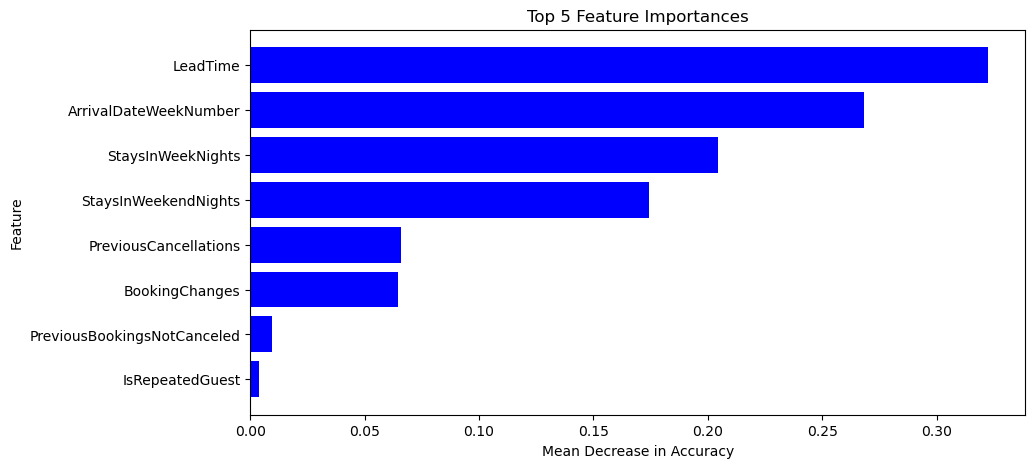

In [34]:
# Sort the feature importances in descending order and select the top 5
indices = np.argsort(importances)[::-1]
top_indices = indices[:10]

# Create a horizontal bar plot
plt.figure(figsize=(10, 5))
plt.title("Top 5 Feature Importances")
plt.barh(range(len(top_indices)), importances[top_indices], color='blue', align='center')
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Feature")
plt.show()


100%|===================| 63226/63464 [01:12<00:00]        

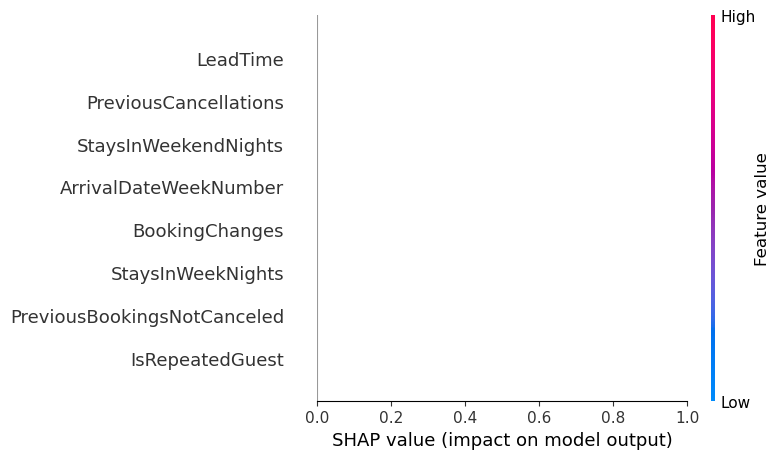

In [35]:
# Select a random subset of data for SHAP analysis
subset = X_train.sample(n=1000, random_state=42)  # Adjust n based on your dataset size

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train, n_jobs=-1)

# Compute SHAP values
shap_values = explainer(X_train)

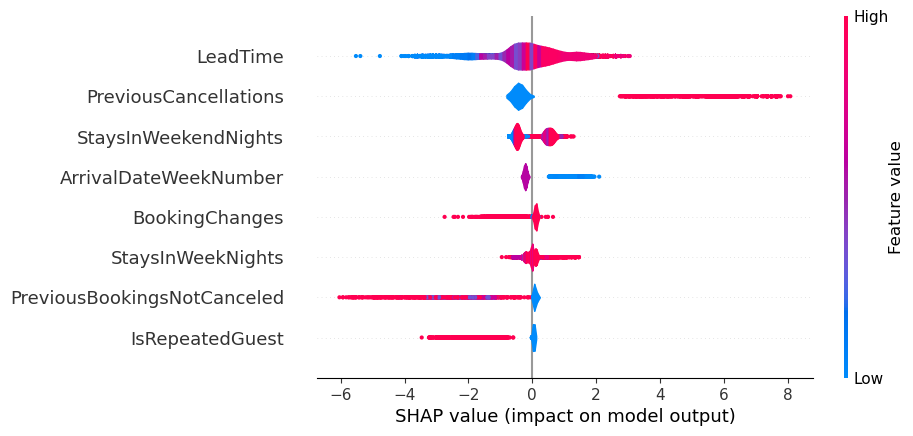

In [36]:
# Generate a violin plot
shap.plots.violin(shap_values)

In [37]:
city_df['LeadTime'].describe()

count   79,330.00
mean       109.74
std        110.95
min          0.00
25%         23.00
50%         74.00
75%        163.00
max        629.00
Name: LeadTime, dtype: float64

<Axes: ylabel='Frequency'>

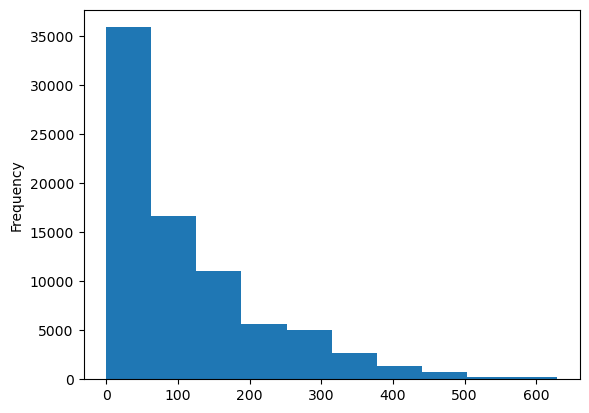

In [43]:
city_df['LeadTime']

<Axes: xlabel='LeadTime', ylabel='IsCanceled'>

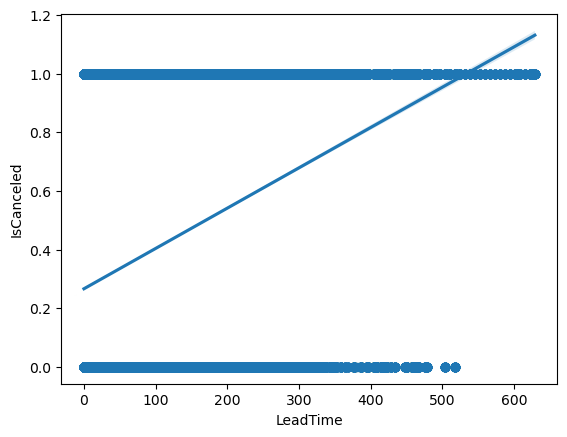

In [54]:
sns.regplot(x = city_df['LeadTime'], y = city_df['IsCanceled'])